In [4]:
import socket 
import matplotlib.pyplot as plt 

def ReadWaveformDataDemo():
    """Read Waveform Data Demo.

    Uses TCP to control RHX software and read 1 second of waveform data,
    as a demonstration of TCP control and TCP data streaming, both of which
    are described in 'IntanRHX_TCPDocumentation.pdf'
    """

    # Connect to TCP command server - default home IP address at port 5000.
    print('Connecting to TCP command server...')
    scommand = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    scommand.connect(('127.0.0.1', 5000))

    # Connect to TCP waveform server - default home IP address at port 5001.
    print('Connecting to TCP waveform server...')
    swaveform = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    swaveform.connect(('127.0.0.1', 5001))

    # Query runmode from RHX software.
    scommand.sendall(b'get runmode')
    commandReturn = str(scommand.recv(COMMAND_BUFFER_SIZE), "utf-8")

    # If controller is running, stop it.
    if commandReturn != "Return: RunMode Stop":
        scommand.sendall(b'set runmode stop')
        # Allow time for RHX software to accept this command before the next.
        time.sleep(0.1)

    # Query sample rate from RHX software.
    scommand.sendall(b'get sampleratehertz')
    commandReturn = str(scommand.recv(COMMAND_BUFFER_SIZE), "utf-8")
    expectedReturnString = "Return: SampleRateHertz "
    # Look for "Return: SampleRateHertz N" where N is the sample rate.
    if commandReturn.find(expectedReturnString) == -1:
        raise GetSampleRateFailure(
            'Unable to get sample rate from server.'
        )

    # Calculate timestep from sample rate.
    timestep = 1 / float(commandReturn[len(expectedReturnString):])

    # Clear TCP data output to ensure no TCP channels are enabled.
    scommand.sendall(b'execute clearalldataoutputs')
    time.sleep(0.1)

    # Send TCP commands to set up TCP Data Output Enabled for wide
    # band of channel A-010.
    scommand.sendall(b'set a-010.tcpdataoutputenabled true')
    time.sleep(0.1)

    # Calculations for accurate parsing
    # At 30 kHz with 1 channel, 1 second of wideband waveform data
    # (including magic number, timestamps, amplifier data) is 181,420 bytes.
    # N = (FRAMES_PER_BLOCK * waveformBytesPerFrame + SizeOfMagicNumber) *
    # NumBlocks where:
    # FRAMES_PER_BLOCK = 128 ; standard data block size used by Intan

    # waveformBytesPerFrame = SizeOfTimestamp + SizeOfSample ;
    # timestamp is a 4-byte int, and amplifier sample is a 2-byte unsigned int

    # SizeOfMagicNumber = 4; Magic number is a 4-byte (32-bit) unsigned int
    # NumBlocks = NumFrames / FRAMES_PER_BLOCK ;
    # At 30 kHz, 1 second of data has 30000 frames.
    # NumBlocks must be an integer value, so round up to 235
    waveformBytesPerFrame = 4 + 2
    waveformBytesPerBlock = FRAMES_PER_BLOCK * waveformBytesPerFrame + 4

    # Run controller for 1 second
    scommand.sendall(b'set runmode run')
    time.sleep(1)
    scommand.sendall(b'set runmode stop')

    # Read waveform data
    rawData = swaveform.recv(WAVEFORM_BUFFER_SIZE)
    if len(rawData) % waveformBytesPerBlock != 0:
        raise InvalidReceivedDataSize(
            'An unexpected amount of data arrived that is not an integer '
            'multiple of the expected data size per block.'
        )
    numBlocks = int(len(rawData) / waveformBytesPerBlock)

    # Index used to read the raw data that came in through the TCP socket.
    rawIndex = 0

    # List used to contain scaled timestamp values in seconds.
    amplifierTimestamps = []

    # List used to contain scaled amplifier data in microVolts.
    amplifierData = []

    for _ in range(numBlocks):
        # Expect 4 bytes to be TCP Magic Number as uint32.
        # If not what's expected, raise an exception.
        magicNumber, rawIndex = readUint32(rawData, rawIndex)
        if magicNumber != 0x2ef07a08:
            raise InvalidMagicNumber('Error... magic number incorrect')

        # Each block should contain 128 frames of data - process each
        # of these one-by-one
        for _ in range(FRAMES_PER_BLOCK):
            # Expect 4 bytes to be timestamp as int32.
            rawTimestamp, rawIndex = readInt32(rawData, rawIndex)

            # Multiply by 'timestep' to convert timestamp to seconds
            amplifierTimestamps.append(rawTimestamp * timestep)

            # Expect 2 bytes of wideband data.
            rawSample, rawIndex = readUint16(rawData, rawIndex)

            # Scale this sample to convert to microVolts
            amplifierData.append(0.195 * (rawSample - 32768))

    # If using matplotlib to plot is not desired,
    # the following plot lines can be removed.
    # Data is still accessible at this point in the amplifierTimestamps
    # and amplifierData.
    plt.plot(amplifierTimestamps, amplifierData)
    plt.title('A-010 Amplifier Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.show()

In [57]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
dirdat = 'C:\\Users\\rairo\\ECE-202-Final-Project\\data\\Feb28\\HomoAnti_3s.mat'

In [49]:
import scipy 
import mne
from scipy.io import loadmat

# Replace 'path_to_your_file.mat' with the actual path to your .mat file
mat = loadmat(dirdat)
mat


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Thu Feb 29 15:21:07 2024',
 '__version__': '1.0',
 '__globals__': ['savedata', 'savetime', 'savesound'],
 'savedata': array([[-48.165, -45.24 , -45.63 , ..., -44.655, -34.125, -38.805],
        [  3.12 ,   7.02 ,   6.825, ...,  -9.945, -10.14 , -12.09 ]]),
 'savetime': array([[0.000000e+00, 2.000000e-04, 4.000000e-04, ..., 3.632634e+02,
         3.632636e+02, 3.632638e+02]]),
 'savesound': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [258]:
#np.array(mat)
data = np.zeros((3,len(mat['savedata'][0])))

data[0:2] = np.array(mat['savedata']) * 1e-6
sound = mat['savesound'][0]
data[2][:]= sound[0:len(data[1])]

Creating RawArray with float64 data, n_channels=3, n_times=1816320
    Range : 0 ... 1816319 =      0.000 ...   181.632 secs
Ready.


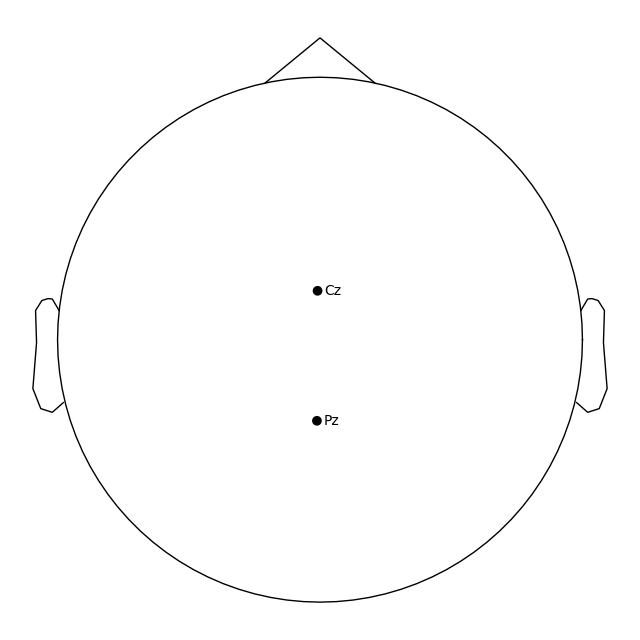

100 events found on stim channel sound
Event IDs: [1 2 3]
100 events found on stim channel sound
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 66001 samples (6.600 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 33001 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


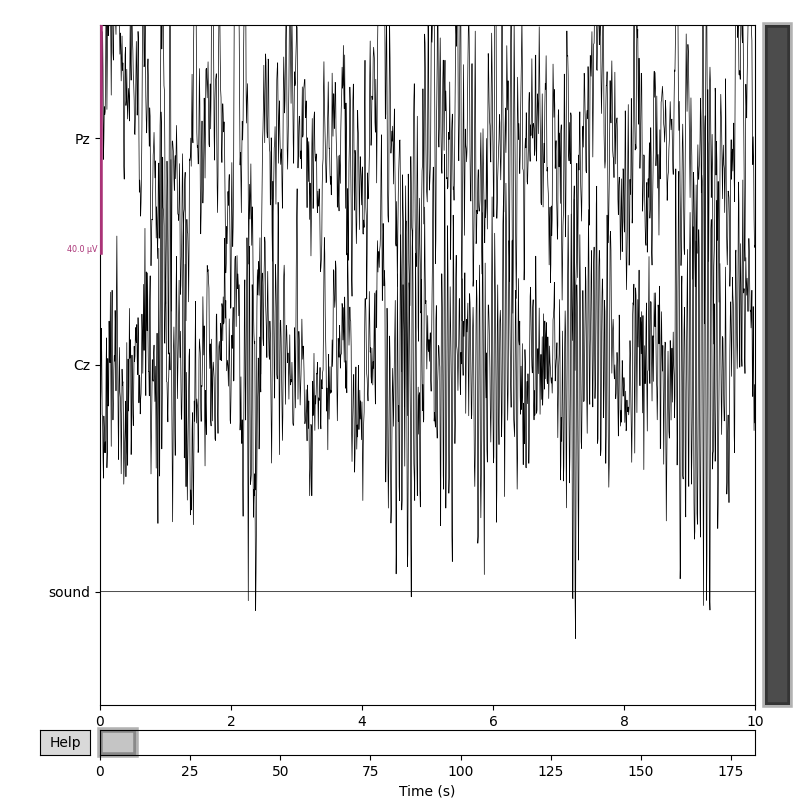

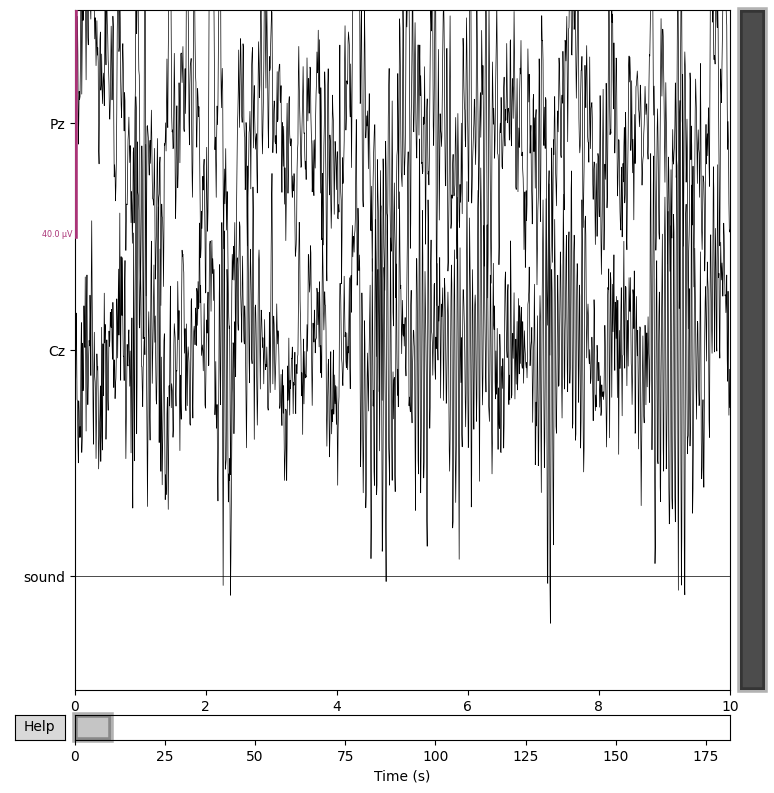

In [270]:
import mne
import numpy as np


montage = mne.channels.make_standard_montage('standard_1020')

# Example: Assuming eeg_data is in shape (n_channels, n_times)
# Create an MNE Info object
info = mne.create_info(
    ch_names=['Pz','Cz','sound'],  # List your channel names
    sfreq=10e3,
    ch_types=['eeg','eeg','stim']
    )



# Convert data to Volts (MNE assumes data in Volts, your data might be in microVolts or another unit)
eeg_data_volts = data # if your data is in microVolts

# Create a RawArray object
raw = mne.io.RawArray(eeg_data_volts, info)

raw.set_montage(montage)
fig = raw.plot_sensors(show_names=True)

raw_downsampled = raw.copy().resample(sfreq=200)

# use a single channel reference (left earlobe)

# Notch filter to remove 50 Hz line noise
raw_notched = raw.copy().notch_filter(freqs=50)
raw_filtered = raw_notched.copy().filter(l_freq=1.0, h_freq=50.0)

# Now, you can use `raw` with MNE functions for analysis.
raw_filtered.set_montage(montage)
raw_filtered.plot()

100 events found on stim channel sound
Event IDs: [1 2 3]


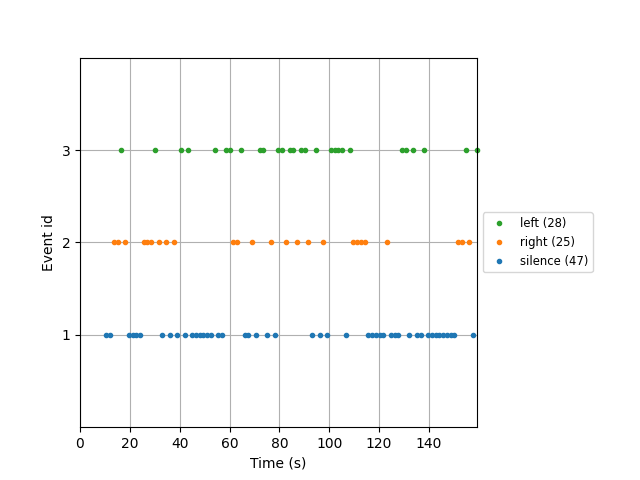

In [266]:
# Example: Extracting the trigger channel's data
stim_data = raw.get_data(picks='sound')  # Replace 'STI 014' with your channel's name
soundplay = mne.find_events(raw,stim_channel='sound', consecutive=False)
event_dict = {'silence':1, 'right':2, 'left':3}
events = soundplay.copy()
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_dict
)


## Joint plots combine butterfly plots with scalp topographies, and provide an excellent first-look at evoked data; by default, topographies will be automatically placed based on peak finding. 

In [289]:
epochs = mne.Epochs(raw_filtered, events=soundplay, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    preload=True, baseline=None)


evoked_l = epochs["left"]
evoked_l.plot_joint(title='left evoked potentials (average)')

evoked_r= epochs['right']
evoked_r.plot_joint(title='right evoked potentials (average)')
epochs.plot_joint(title='epochs avg')

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 7001 original time points ...
0 bad epochs dropped


AttributeError: 'Epochs' object has no attribute 'plot_joint'

In [283]:
epochs.plot(picks="eeg",  gfp=True)

TypeError: BaseEpochs.plot() got an unexpected keyword argument 'gfp'

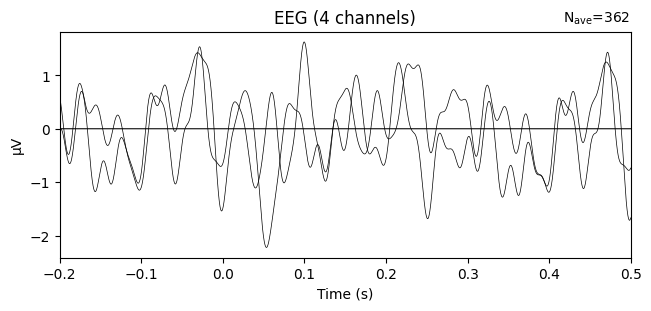

    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\rairo\AppData\Local\Temp\ipykernel_36608\4032686734.py:7: UserWarning: Zero value in spectrum for channel ch2
  epochs.compute_psd()


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,362
Dims,"epoch, channel, freq"
Estimation method,multitaper
Number of channels,4
Number of frequency bins,3501
Frequency range,0.00 – 4999.29 Hz


In [111]:
mne.viz.plot_compare_evokeds(
    evks,
    picks="MEG 1811",
    colors=dict(aud=0, vis=1),
    linestyles=dict(left="solid", right="dashed"),
    time_unit="ms",
)

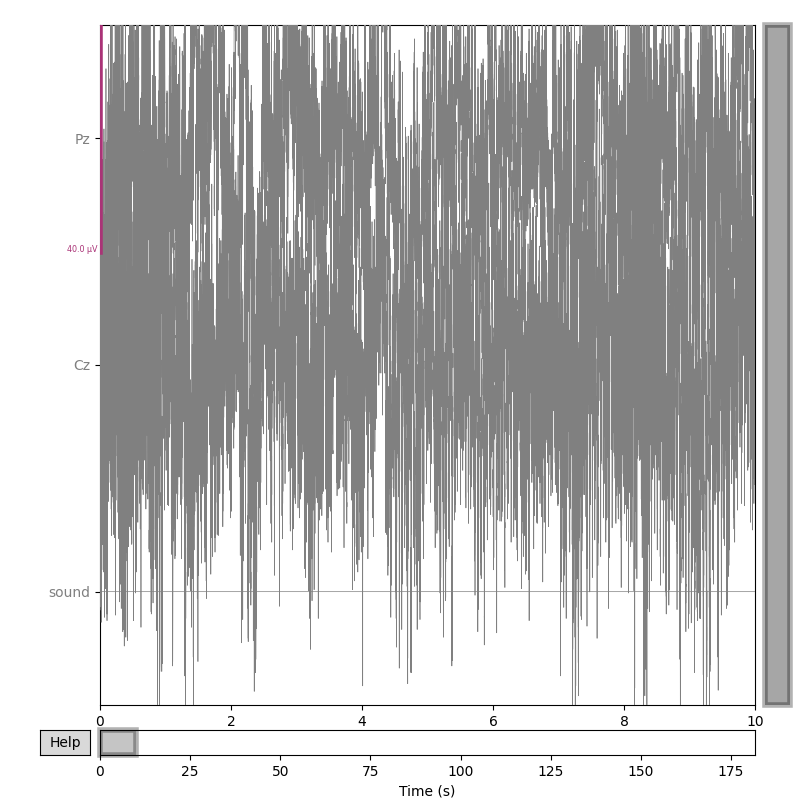

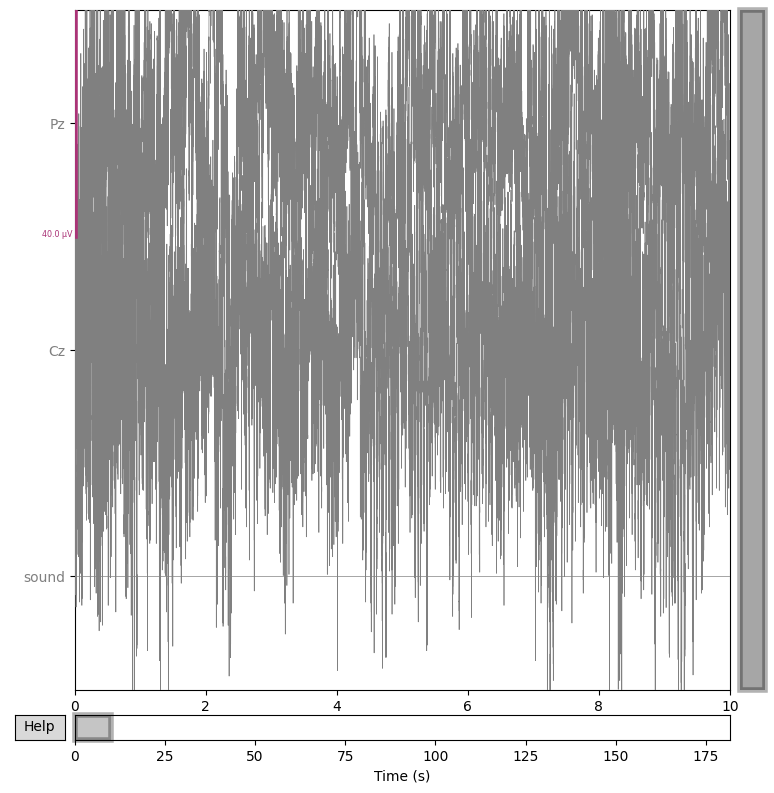

In [253]:
raw.plot(
    events=events,
    start=0,
    duration=10,
    color="gray",
    event_color={1: "r", 2: "g", 3: "b"},
)